In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import skfuzzy as fz
from skfuzzy import control as ctrl
import math

## 1a - Setup membership functions for fuzzy variables

The rules were created with the singleton method to create triangule relationships for each of the given fuzzy variable and added subsequent overlap to provide a transition between each state smothly in our fuzzy system. We wanted to have no gaps in the membership function output being projected into the control output space. We also added open limits on the speed and steering so both the "stop" and "max" speed values would be inclued as possible actions within the given states, so the robot could stop if need to and still reach its maximum speed

In [2]:
#Setup variables for universe and their ranges
#Input with respect to object
distance = ctrl.Antecedent(np.arange(0, 10, 0.5), 'distance')
angle    = ctrl.Antecedent(np.arange(0, 90, 1), 'angle')

#Resulting action to take
speed = ctrl.Consequent(np.arange(0, 5, 0.2), 'speed')
steer  = ctrl.Consequent(np.arange(0, 90, 1), 'steer')

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


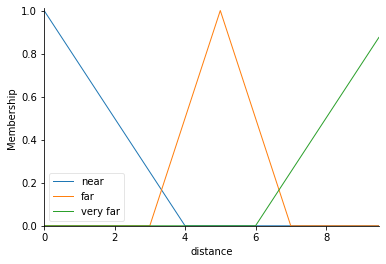

In [3]:

#Set up custom memberships for each variable and output
distance['near'] = fz.trimf(distance.universe, [0, 0, 4]) 
distance['far'] = fz.trimf(distance.universe,  [3, 5, 7]) 
distance['very far'] = fz.trimf(distance.universe,  [6, 10, 10])

#seems to be broken outside of using this in ipython. *smh*
distance.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


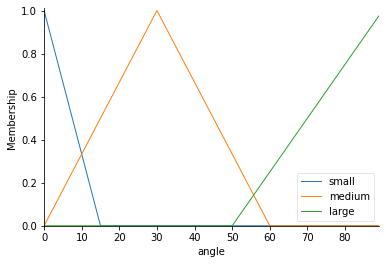

In [4]:

#Set up custom memberships for each variable and output
angle["small"] = fz.trimf(angle.universe, [0, 0, 15]) 
angle["medium"] = fz.trimf(angle.universe,  [0, 30, 60]) 
angle["large"] = fz.trimf(angle.universe,  [50, 90, 90])

#seems to be broken outside of using this in ipython.
angle.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


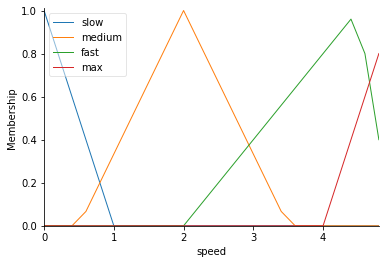

In [5]:

#Set up custom memberships for each variable and output
speed['slow'] = fz.trimf(speed.universe, [0, 0, 1]) 
speed['medium'] = fz.trimf(speed.universe,  [0.5, 2, 3.5]) 
speed['fast'] = fz.trimf(speed.universe,  [2, 4.5, 5])
speed['max'] = fz.trimf(speed.universe,  [4, 5, 5])

#seems to be broken outside of using this in ipython.
speed.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


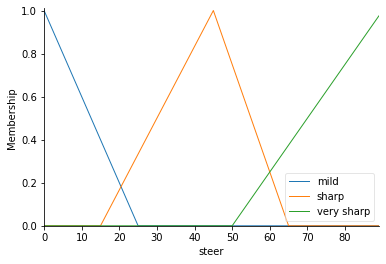

In [6]:
#Set up custom memberships for each variable and output
steer['mild'] = fz.trimf(steer.universe, [0, 0, 25]) 
steer['sharp'] = fz.trimf(steer.universe,  [15, 45, 65]) 
steer['very sharp'] = fz.trimf(steer.universe,  [50, 90, 90])


#seems to be broken outside of using this in ipython.
steer.view()

## 1b) Setup Fuzzy Rules

The fuzzy rule set was created and applied for each input andecents and resulting consequent of steering and speed for the given inputs. An output was created for every possible combination of inputs to cover the full range of possible states and scenarios

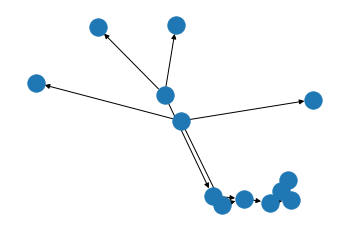

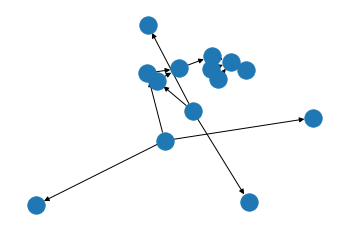

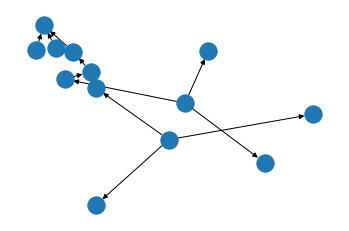

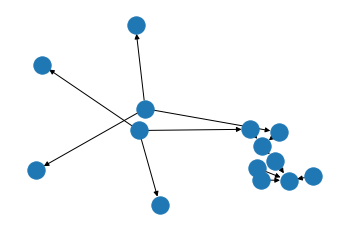

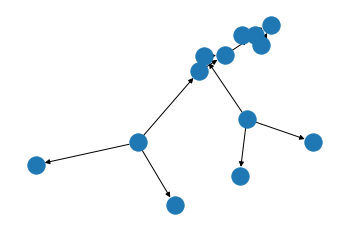

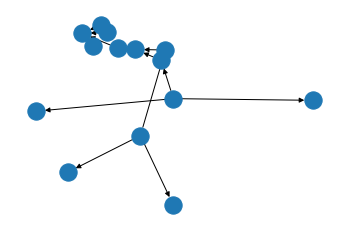

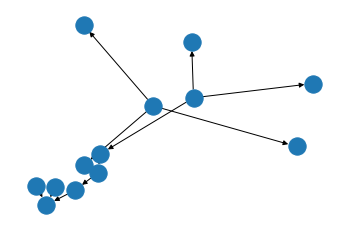

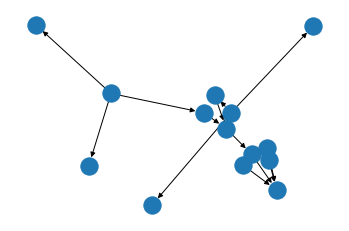

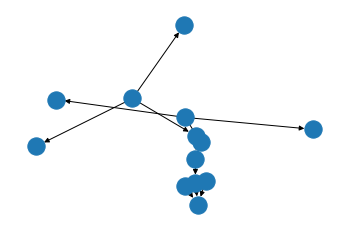

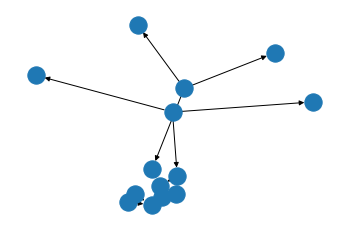

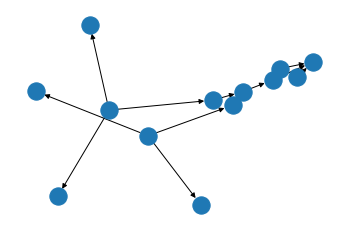

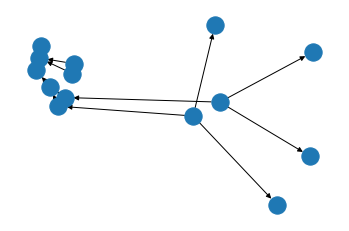

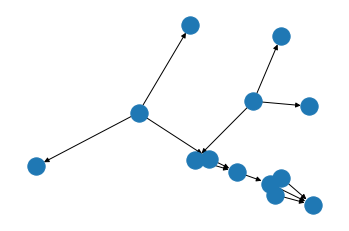

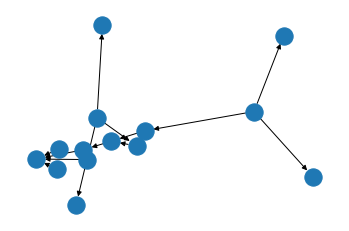

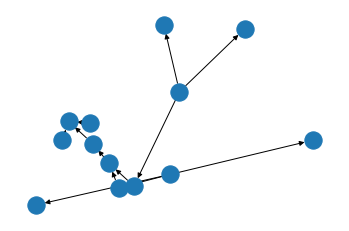

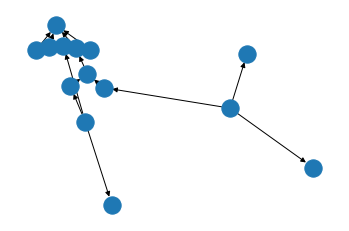

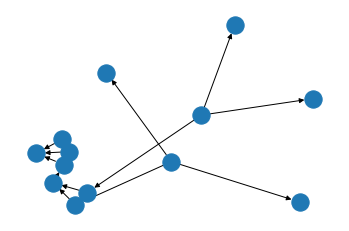

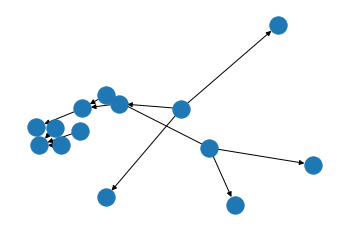

In [7]:
rules = []
rules.append(ctrl.Rule(distance['near'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['near'] & angle['large'], speed['fast']))

rules.append(ctrl.Rule(distance['near'] & angle['medium'], steer['sharp']))
rules.append(ctrl.Rule(distance['near'] & angle['medium'], speed['medium']))

rules.append(ctrl.Rule(distance['near'] & angle['small'], steer['very sharp']))
rules.append(ctrl.Rule(distance['near'] & angle['small'], speed['slow']))


rules.append(ctrl.Rule(distance['far'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['far'] & angle['large'], speed['fast']))

rules.append(ctrl.Rule(distance['far'] & angle['medium'], steer['sharp']))
rules.append(ctrl.Rule(distance['far'] & angle['medium'], speed['medium']))

rules.append(ctrl.Rule(distance['far'] & angle['small'], steer['sharp']))
rules.append(ctrl.Rule(distance['far'] & angle['small'], speed['medium']))


rules.append(ctrl.Rule(distance['very far'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['large'], speed['max']))

rules.append(ctrl.Rule(distance['very far'] & angle['medium'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['medium'], speed['fast']))

rules.append(ctrl.Rule(distance['very far'] & angle['small'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['small'], speed['medium']))

for rule in rules:
    rule.view()

## 1c-d) Setup inferencing system for rules

The inferencing rules in this case levearges the sci-fuzzy libraries use of the mamdani inferenceing and for defuzzification we used centroid method for our output. This was handled within the library by default when setting the rules within 

In [ ]:
speed.defuzzify_method='centroid'
steer.defuzzify_method='centroid'

## 2) Explain reasining for using inference and defuzzification methods

The mamdani method of inference was chosen due to its output speed as well as simplicity during computation. The centroid defuzzification was also used. Centroid mehtod was chosen to smooth the robot movement, otherwise the robot movement would under or over shoot the trajectory needed if say the max or min was used instead. Mean of max was not used as the centroid as it gives a conservative estimate of all the other sensors. Mean of max would only look at the average of max signals. The centroid method in turn would select the output based on the weighting of the overall control signal and not just the average of the peaks.  This would implictly include more input information in the decision of the control signal.

## 3) Resulting Simulation output for fuzzy system

The resulting controller was created and then simulated over a random set of appearing obstacles to be within the range of the robot, of +/-90 of the heading of the robot so no obstacle would be spawned behind the robot but infront. The assumpotions here assumes that the robot starts also at the zero position in the global reference frame, and each obstacle exists in the global frame as well. Once the absolute value of the angle between the rovers heading and obstacle was larger than 90 degrees another obstacle would be generated as the previous one was avoided. This allowed us to on the fly come up with a trajectory using the fuzzy control set to robustly test our system.

Graphs of the inputs are provided after each target is deemed to be "passed". The resulting fuzzy infered and defuzzified output is also shown after, with the resulting membership to be shadded. The crisp value is then used to progress the robot at each time step, until a new value is determined from the fuzzy system, on new target aquisition. The final trajectory is plotted in the last graph which shows the entire world frame, in orange, the robot steerring and speed changes are coloured points along the trajectory, while obstacles are numbered and are in blue.

In [8]:
ctrl_system = ctrl.ControlSystem(rules)
ctrl_sim = ctrl.ControlSystemSimulation(ctrl_system)

We have steered passed our target: theta = 93.49947534918081
steering angle: 10.454318305966725
speed: 3.6065652622317494
We have steered passed our target: theta = 94.46879989134986
steering angle: 41.132703612770044
speed: 1.9999999999999996
We have steered passed our target: theta = 105.92775287899637
steering angle: 10.158727728555881
speed: 3.6369826853782867
We have steered passed our target: theta = 93.65482106168184


/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8

steering angle: 10.956953917816675
speed: 3.5552841186631463
We have steered passed our target: theta = 141.22099497844403
steering angle: 8.449074074074073
speed: 4.533333333333334
We have steered passed our target: theta = 129.87733310846195
steering angle: 9.72222222222222
speed: 3.6800307219662063
We have steered passed our target: theta = 92.68903495915418


/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8

steering angle: 11.348996373222816
speed: 3.5155917485971586
We have steered passed our target: theta = 114.53882756953499
steering angle: 9.185606060606059
speed: 3.72987657409724
We have steered passed our target: theta = 124.74492446564459
steering angle: 9.72222222222222
speed: 4.506060606060607
We have steered passed our target: theta = 90.22686181415192
steering angle: 8.669088071936848
speed: 4.533139192464097
sim done
[array(0), array(10.45431831), array(41.13270361), array(10.15872773), array(10.95695392), array(8.44907407), array(9.72222222), array(11.34899637), array(9.18560606), array(9.72222222), array(8.66908807)]


/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/theonidus/.local/lib/python3.8

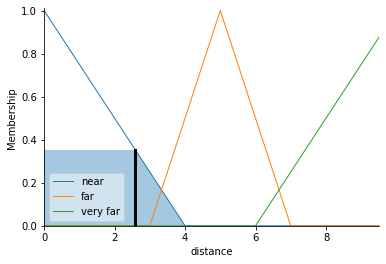

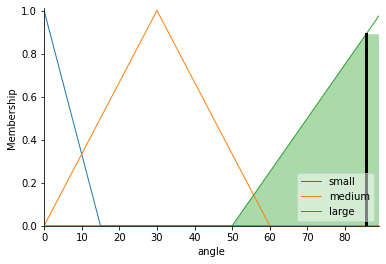

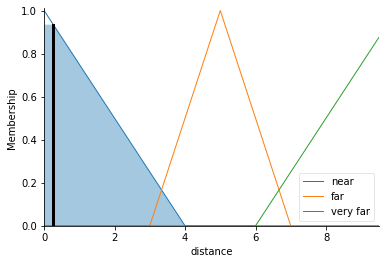

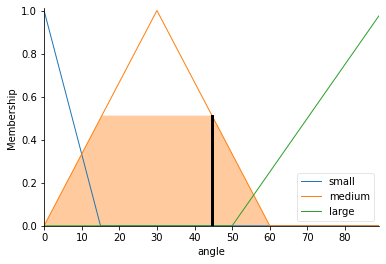

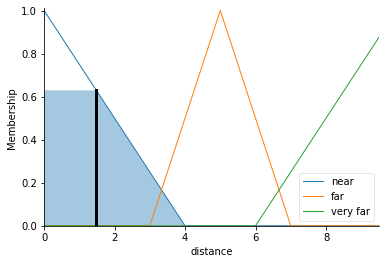

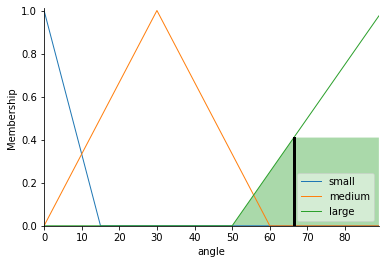

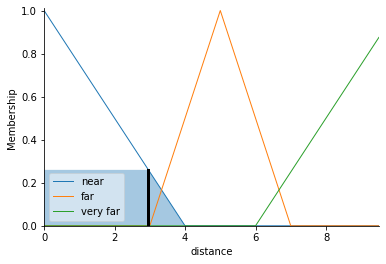

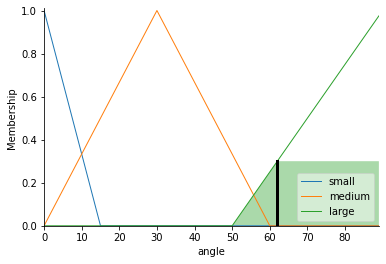

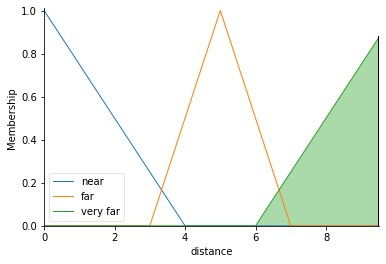

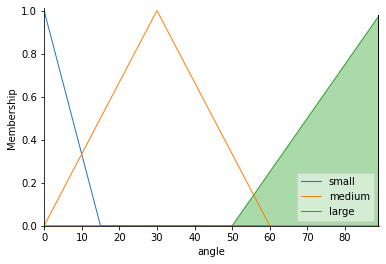

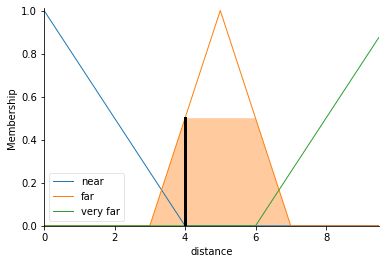

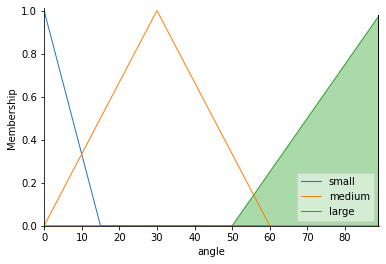

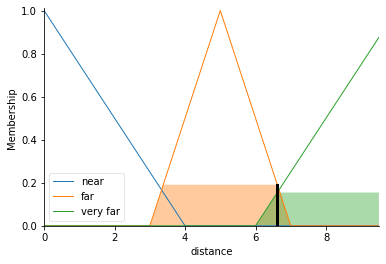

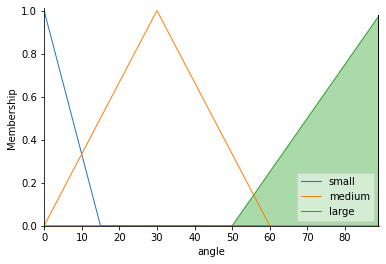

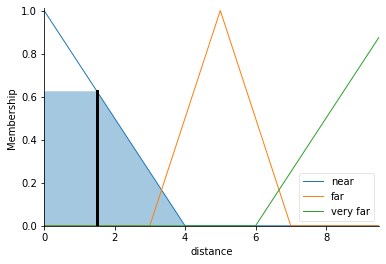

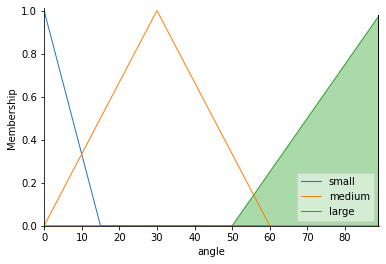

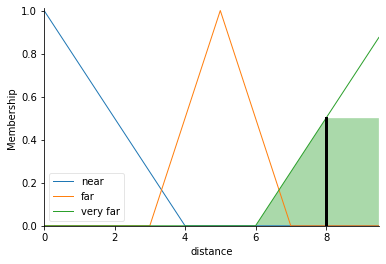

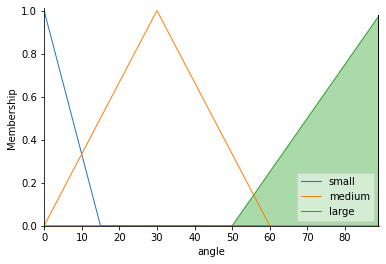

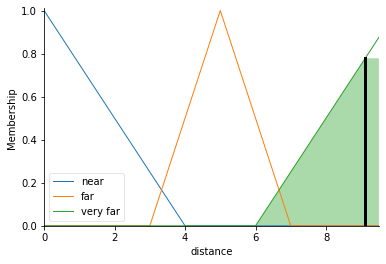

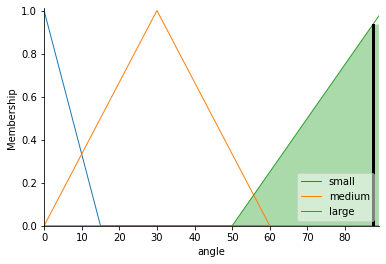

In [9]:
# ASSUMPTION 0: units are in meters, m/s, and degrees
# ASSUMPTION 1: control frequency is 100ms
# ASSUMPTION 2: start our speed and steering at 0
# ASSUMPTION 3: the environment is boundless (no walls)
# ASSUMPTION 4: we have one obstacle to avoid at a time
# ASSUMPTION 5: once we pass an obstacle (|ang| > 90) the next one is spawned
# ASSUMPTION 6: the obstacle spawns at a random distance from the robot between 1-11m
# ASSUMPTION 7: obstacles spawn at a random angle between -90 and 90
# ASSUMPTION 8: running sim for 10 seconds
# ASSUMPTION 9: assuming singleton input values

# ASSUMPTION 10: Robot starts at 0,0 in the global world frame
# ASSUMPTION 11: obstacles position and angle are mapped in the world frame
# ASSUMPTION 12: The front of the robot is used to determine the angle 0 relative to the world frame
# ASSUMPTION 13: The center of the robot is used as the point of reference for position calculations

dt = 0.1
runtime = 10 # seconds
steps = math.floor(runtime / dt)


speed = 0 
steer = 0
pos = [0, 0]
positions = []
positions.append(np.copy(pos))
obstacles = []
pos_at_target_change = []
steering_angles = []
steering_angles.append(np.copy(steer))
steering_angle_at_target_change = []

np.random.seed(0)

def deg_to_rad(deg):
    rad = deg*np.pi/180
    return rad

def rad_to_deg(rad):
    deg = rad*180/np.pi
    return deg

def gen_random_obstacle(pos, steer):
    # select a random angle between -90 to 90 instead of +- 90
    # this way our obstacles are a little more in the way
    ang = np.random.choice(np.arange(-90, 90, 1))
    # choose a random dist between 1 and 11
    dist = np.random.choice(np.arange(1, 11, 0.5))
    # make the target angle relative to the robot heading
    # this way it is +/-90 from our current heading, not behind us
    ang = ang + steer
    dx = np.cos(deg_to_rad(ang)) * dist
    dy = np.sin(deg_to_rad(ang)) * dist
    
    # remove small values from numerical limitations
    thres = 1e-10
    if abs(dx)<thres:
        dx = 0
    if abs(dy)<thres:
        dy=0

    obstacle = [pos[0] + dx, pos[1] + dy]
    return obstacle

def get_input(obstacle, pos, steer):
    # calculates the actual angle between robot and obstacle, and
    # the distance. These will be our simulated sensor values
    
    # vector from position to obstacle
    robot_to_obstacle = np.asarray(obstacle) - np.asarray(pos)
    # vector along which rover is moving
    dx = np.sin(deg_to_rad(steer))
    dy = np.cos(deg_to_rad(steer))
    future_pos = np.array([pos[0]+dx, pos[1]+dy])
    robot_to_steer = (future_pos - np.asarray(pos))
    
    unit_vec1 = robot_to_obstacle / np.linalg.norm(robot_to_obstacle)
    unit_vec2 = robot_to_steer / np.linalg.norm(robot_to_steer)
    dot = np.dot(unit_vec1, unit_vec2)
    ang = rad_to_deg(np.arccos(dot))

    dist = np.linalg.norm(np.asarray(pos)-np.asarray(obstacle))
    return dist, ang

def next_pos(steer, speed, pos, dt):
    # calculate the next robot position given the heading and speed
    step_size = speed * dt
    dx = np.sin(deg_to_rad(steer)) * step_size
    dy = np.cos(deg_to_rad(steer)) * step_size
    pos[0] += dx
    pos[1] += dy
    return pos

angle_sign = 1

for ii in range(steps):
    if (ii == 0):
        obstacle = gen_random_obstacle(pos=pos, steer=steer)
        pos_at_target_change.append(np.copy(pos))
        dist, ang = get_input(obstacle, pos, steer)
        steering_angle_at_target_change.append(np.copy(steer))
        obstacles.append(obstacle)

    # calculate our distance and angle to target to simulate our sensors
    dist, ang = get_input(obstacle, pos, steer)

    # our fuzzy system takes positive inputs, so store the sign here to restore it later
    angle_sign = np.sign(ang)

    if abs(ang) > 90:
        print(f"We have steered passed our target: theta = {ang}")
        distance.view(sim=ctrl_sim)
        angle.view(sim=ctrl_sim)
        print(f"steering angle: {ctrl_sim.output['steer']}")
        print(f"speed: {ctrl_sim.output['speed']}")
        obstacle = gen_random_obstacle(pos=pos, steer=steer)
        pos_at_target_change.append(np.copy(pos))
        steering_angle_at_target_change.append(np.copy(steer))
        obstacles.append(obstacle)
        dist, ang = get_input(obstacle, pos, steer)

    # run a step of our sim
    ctrl_sim.input['distance'] = dist
    ctrl_sim.input['angle'] = ang
    ctrl_sim.compute()

    # retrieve our control outputs
    speed = ctrl_sim.output['speed']
    # restore the sign of our angle so we know whether to turn left or right
    steer = angle_sign * ctrl_sim.output['steer']

    # calculte our updated position
    pos = next_pos(steer=steer, speed=speed, pos=pos, dt=dt)
    positions.append(np.copy(pos))
    steering_angles.append(np.copy(steer))

print('sim done')
print(steering_angle_at_target_change)

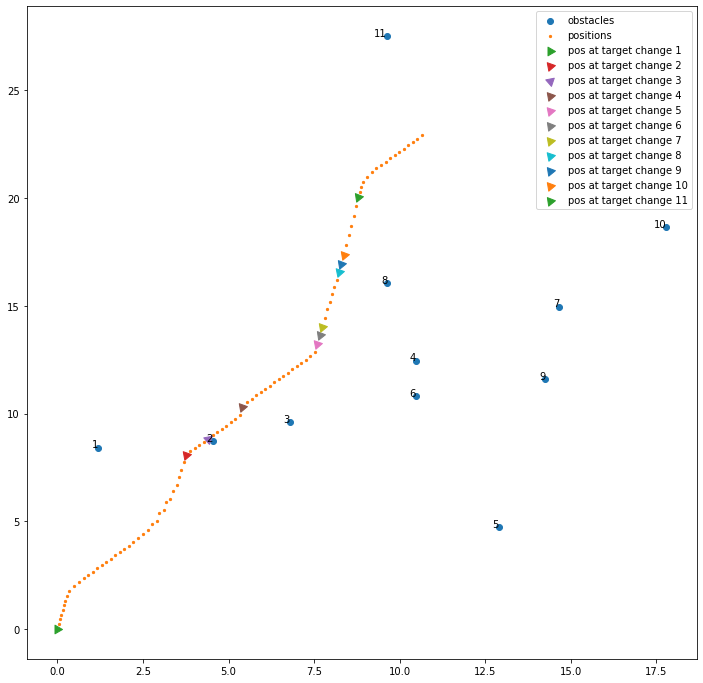

In [10]:
obstacles = np.asarray(obstacles)
positions = np.asarray(positions)
pos_at_target_change = np.asarray(pos_at_target_change)


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.scatter(obstacles[:, 0], obstacles[:, 1], label='obstacles')
for ii, obstacle in enumerate(obstacles):
    plt.text(obstacle[0], obstacle[1], f"{ii+1}", horizontalalignment='right')
plt.scatter(positions[:, 0], positions[:, 1], label='positions', s=5)
for ii in range(0, len(pos_at_target_change)):
    plt.scatter(
        pos_at_target_change[ii, 0],
        pos_at_target_change[ii, 1],
        marker=(3, 0, steering_angle_at_target_change[ii]-90),
        s=100,
        label=f'pos at target change {ii+1}')

plt.legend()
plt.savefig('obstacle_avoidance.png')
plt.show()